In [2]:
import os
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
import imutils

In [3]:
root = 'rosagro_test/train/'
data = os.listdir(root)

data = [root + filename for filename in data]

# EDA изучим наш датасет.
**Датасет представляет собой изображения одинаковых бассейнов под ЖОУ (жидкие органические удобрения)**

**Нашей задачей является сделать one-shot детектор, который будет определять уровень ЖОУ**

**Из-за размера датасета (очень маленький), будем смотреть в сторону инструментов, основанных на свертках, градиентах**

**Особые черты которые можно увидеть:**
- Бассейны условно одинаковые, расположение камеры тоже, перпендикуляр к стене, выравнивание по горизонту
- Вокруг каждого бассейна с ЖОУ мы имеем ограждения. Пологаю это обязательное условие эксплуатации. Мы можем использовать это как верхнюю границу
- ЖОУ достаточно темные и находятся внизу. Это значит темные градиенты будут на границах и больше всего в углах
- Когда ЖОУ оседает, имеет блестящую поверхность - будут отражения
- ЖОУ оставляет на стенках бассейна осадок, затеняя светлый бетон

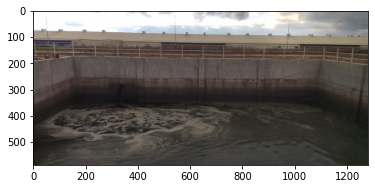

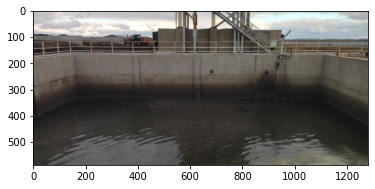

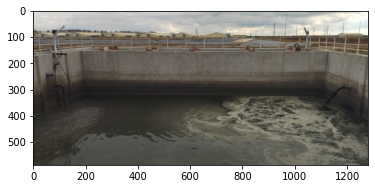

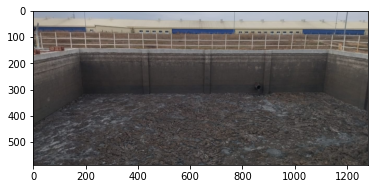

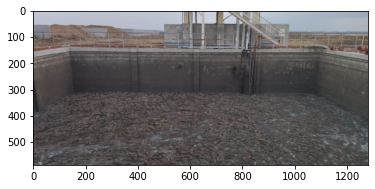

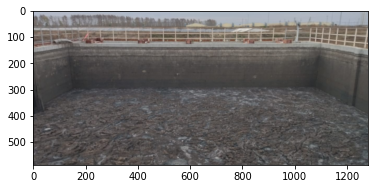

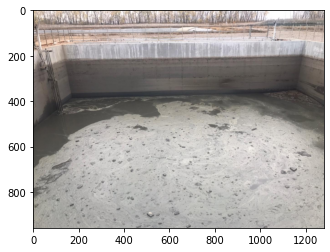

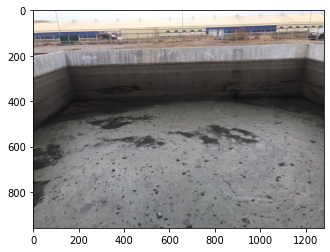

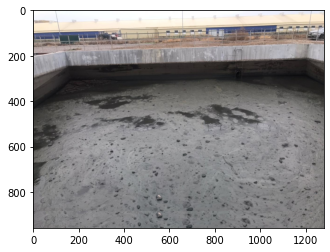

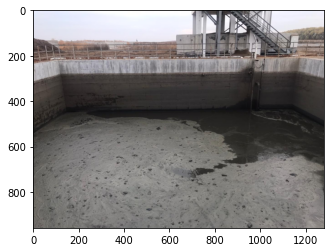

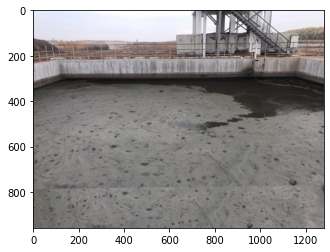

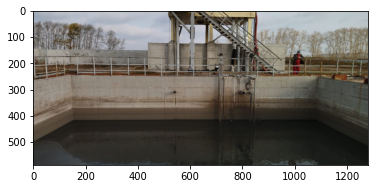

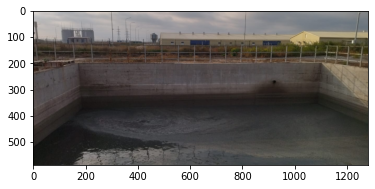

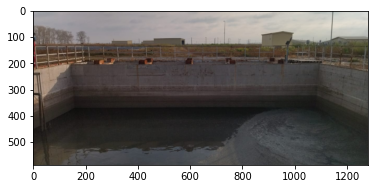

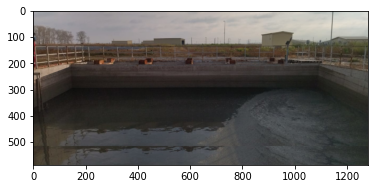

In [12]:
for file in data:
    src = cv2.imread(cv2.samples.findFile(file), cv2.IMREAD_COLOR)
    src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    plt.imshow(src)
    plt.show()

In [ ]:
def treshold(filename):
    src = cv2.imread(cv2.samples.findFile(filename), cv2.IMREAD_GRAYSCALE)
    # сглаживаем, не размывая контуров
    sigmaX = 10
    sigmaY = 10
    kernel = (5, 5)
    img_blur = cv2.GaussianBlur(src, kernel, sigmaX=sigmaX, sigmaY=sigmaY)
    dst = cv2.threshold()



**Начнем с поиска верхней границы бассейна**

In [ ]:
def horizontal_houghLines(filename):
    src = cv2.imread(cv2.samples.findFile(filename), cv2.IMREAD_GRAYSCALE)




    # Выделяем контуры
    threshold1 = 20
    threshold2 = 120
    edges = None,
    apertureSize = 3
    L2gradient = None

    detected_edges = cv2.Canny(img_blur,
                               threshold1,
                               threshold2,
                               edges,
                               apertureSize,
                               L2gradient)

    # применяем маску
    mask = detected_edges != 0
    dst = img_blur * (mask[:, :].astype(img_blur.dtype))

    # Копируем чтобы показать на вьюхе
    cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    lines_cdst = np.copy(cdst)

    # Ищем контуры
    contours = cv2.findContours(dst.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    for count in contours:
        epsilon = 0.01 * cv2.arcLength(count, True)
        approximations = cv2.approxPolyDP(count, epsilon, True)
        cv2.drawContours(lines_cdst, [approximations], 0, (0), 3)

    # вероятности вертикальных линий
    lines_prob = cv2.HoughLinesP(dst, 1, np.pi, 2, None, 30, 20)
    if lines_prob is not None:
        for i in range(0, len(lines_prob)):
            l = lines_prob[i][0]
            x0, y0, x1, y1 = l
            if abs(x0 - x1) == 0:  # vertical only
                cv2.line(lines_cdst, (x0, y0), (x1, y1), (0, 0, 255), 3, cv2.LINE_AA)

    cv2.imshow("Source", src)
    # cv2.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)
    cv2.imshow("Detected Vertical Lines (in red)", lines_cdst)

    k = cv2.waitKey(0) & 0xFF
    if k == 27:  # close on ESC key
        cv2.destroyAllWindows()